In [1]:
import pandas as pd
import numpy as np

#### Read and merge data

In [2]:
#read two data files
df = pd.read_excel('secom.xlsx',header= None)
label = pd.read_excel('secom_labels.xlsx', header = None)

In [3]:
#merge two data sets
label.columns = ['class', 'time']
df = df.add_suffix('_sensor')
data = pd.concat([label,df], axis=1)
data.head()

,class,time,0_sensor,1_sensor,2_sensor,3_sensor,4_sensor,5_sensor,6_sensor,7_sensor,...,580_sensor,581_sensor,582_sensor,583_sensor,584_sensor,585_sensor,586_sensor,587_sensor,588_sensor,589_sensor
0,-1,19/07/2008 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,-1,19/07/2008 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,1,19/07/2008 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,-1,19/07/2008 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,-1,19/07/2008 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


#### Clean and prepare data

Clean dataset, impute missing values. 

First, check whether target attribute has NaN, if yes, drop NaN in class, since imputing class label is not that reasonable.

In [4]:
print(sum(data['class'].isnull()))

0


Target varibles have no NaN. 

Check whether time_stamp has NaN. Again, this one is not reasonable to impute values. 

In [5]:
print(sum(data['time'].isnull()))

0


No missing values in time_stamp.

Next step, we can loop through each column, and impute missing values with median.

In [6]:
for i in range(0,590):
    name = str(i) +'_sensor'
    HasNan =data[name].isnull()
    if sum(HasNan) > 0:
        data.loc[HasNan, name] =  np.mean(data[name])

Data is cleaned with missing values.

There is no more missing values.  Let's take care of time_stamp data. Time_stamp data is a little bit messy, has different kind of format

In [7]:
#convert time_stamp to datetime format
data['time'] = pd.to_datetime(data['time'])

Now, the data is cleaned and ready for further exploration.

#### Visually explore data

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns 

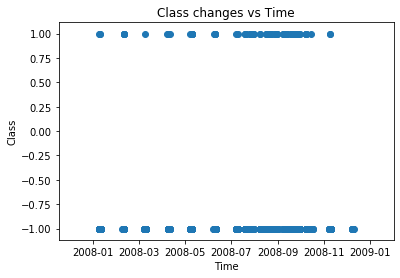

In [9]:
plt.scatter(data['time'],data['class'])
plt.xlabel('Time')
plt.ylabel('Class')
plt.title('Class changes vs Time');

No significant difference can be seen in this plot. But data are more concentrated in the region from 2008-09 to 2008-11.

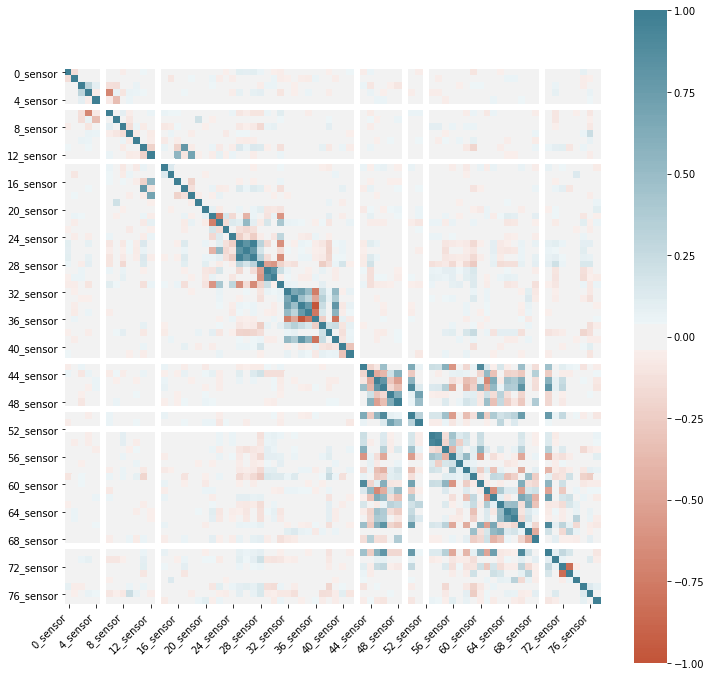

In [10]:
#plot correalations between variables
sub_data = data.iloc[:,2:80]
corr = sub_data.corr()
fig,ax =plt.subplots()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
fig.set_size_inches(12,12)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

From this correaltion matrix plot, we can see that some of the corrlations are positve (blue), some of them are negative (red). But most of them are grey, suggesting that variables are not related to each other. Notice that there are a few lines are pure white, suggesting the corresponding sensor doesn't have variance (that means it has constant values). A sensor has constant value is suspectable though. Another observation is sensors have higher correlation values to its neighbor sensors, implying that the nearby sensors are probably testing similar properties.

Let's randomly choose two correlated sensors to see whether they have linear relationship. 

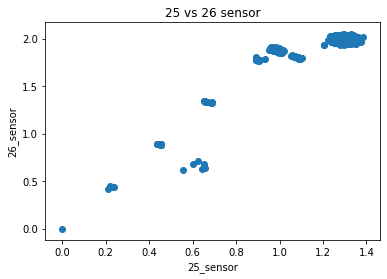

In [11]:
# sensor 25 and sensor 26 have a dark blue color, indicating they are correlated.
plt.scatter( data['25_sensor'],data['26_sensor'])
plt.xlabel('25_sensor')
plt.ylabel('26_sensor')
plt.title('25 vs 26 sensor');

By only look at data of these two, it seems like they have linear dependence. This could imply that the property of 25 is linear related to property of 26.

#### Handle class imbalance problem

In [12]:
# import SMOTE package
from collections import Counter
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import train_test_split

In [13]:
# handle imbalance data set using SMOTE
X = data.iloc[:,2:]
y= data['class']

#split data first, then apply SMOTE on the training data set
X_train, X_test, y_train, y_test = train_test_split (X,y, random_state =0)

print('Original dataset shape {}'.format(Counter(y)))
sm = SMOTE(random_state=0)
X_res, y_res = sm.fit_sample(X_train, y_train)
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({-1: 1463, 1: 104})
Resampled dataset shape Counter({-1: 1092, 1: 1092})


## Apply feature selection techniques to reduce dimensionality of data

### Stepwise Model Selection


#### Forward feature selection

In [14]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression

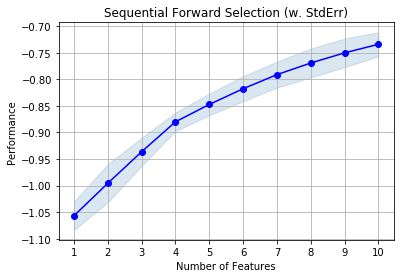

In [15]:
lr = LinearRegression()

sfs = SFS(lr, 
          k_features=10, # k_features has to be smaller or equal to the number of features. If equal to, it starts from
                         # intercept to the full model
          forward=True,  # forward
          floating=False, 
          scoring='neg_mean_squared_error',
          cv=10)

sfs = sfs.fit(X_res, y_res)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

Using 10 features, we can see the performance are improving with number of features. Let's try to increase the number of features.

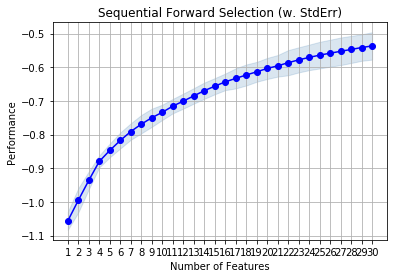

In [16]:
sfs = SFS(lr, 
          k_features=30, # k_features has to be smaller or equal to the number of features. If equal to, it starts from
                         # intercept to the full model
          forward=True,  # forward
          floating=False, 
          scoring='neg_mean_squared_error',
          cv=10)

sfs = sfs.fit(X_res, y_res)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [17]:
sfs.get_metric_dict()[30]

{'feature_idx': (14,
  31,
  59,
  64,
  67,
  68,
  75,
  77,
  82,
  86,
  99,
  102,
  124,
  129,
  131,
  132,
  202,
  212,
  281,
  310,
  312,
  337,
  437,
  439,
  453,
  486,
  487,
  488,
  500,
  511),
 'cv_scores': array([-0.72376746, -0.72420322, -0.62584177, -0.49579676, -0.63365566,
        -0.49453008, -0.43670871, -0.42192242, -0.40164822, -0.4094432 ]),
 'avg_score': -0.5367517476034201,
 'feature_names': ('14_sensor',
  '31_sensor',
  '59_sensor',
  '64_sensor',
  '67_sensor',
  '68_sensor',
  '75_sensor',
  '77_sensor',
  '82_sensor',
  '86_sensor',
  '99_sensor',
  '102_sensor',
  '124_sensor',
  '129_sensor',
  '131_sensor',
  '132_sensor',
  '202_sensor',
  '212_sensor',
  '281_sensor',
  '310_sensor',
  '312_sensor',
  '337_sensor',
  '437_sensor',
  '439_sensor',
  '453_sensor',
  '486_sensor',
  '487_sensor',
  '488_sensor',
  '500_sensor',
  '511_sensor'),
 'ci_bound': 0.09052422547016588,
 'std_dev': 0.12188319241011601,
 'std_err': 0.04062773080337201}

Using 30 features, we can see that the performance gradually levels off, suggesting that increasing the number of features doesn't contribute a lot for performance improvement. I didn't further increase the number of features for the sake of short running time. 

#### Backward feature selection

From forward feature selection, we learned that more 30 features yield the best performance, so we also use 30 features in backward feature selection.

In [18]:
# Recursive Feature Elimination
from sklearn.feature_selection import RFE #Recursive Feature Elimination
from sklearn.linear_model import LinearRegression

estimator = LinearRegression()
selector = RFE(estimator, 30, step=1)#select 30 features. Step=1 means each step only remove 1 variable from the model
selector = selector.fit(X_res, y_res)
print(selector.support_) # The mask of selected features.
print(selector.ranking_) # selected features are ranked 1. The 6th is the one that is removed first,
                         # 2nd is the one that is removed last

C:\Users\zhuoy\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=30 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
  True False False False False False False  True False  True False False
  True False  True False False  True  True False  True  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False  True False False False False False False False False
 False False False False False False False False Fa

In [19]:
selected = selector.support_
backward = [i for i, x in enumerate (selected ) if x]
print('index for selected feature in backward selection:', backward)

index for selected feature in backward selection: [34, 36, 43, 45, 48, 50, 53, 54, 56, 57, 100, 101, 143, 147, 172, 174, 220, 238, 239, 254, 278, 282, 376, 377, 392, 543, 544, 579, 580, 588]


In [20]:
#find the common features selected from both models
forward = [14,31,32,40,59,64,65,67,75,90,99,103,104,121, 131,145,151,155,188,198,200,290,312,433,437,445,488,499,511,575]
set(backward) & set(forward)

set()

No feature is found in both forward and backward selections.Different algorithms give the different optimal value.  It would be interesting to see which one perofrms better when applying to model.

#### LASSO

In [21]:
# LASSO, this is the classification problem, we need to use LogisticRegression with L1 penalty
from sklearn import linear_model

clf = linear_model.LogisticRegression(penalty='l1',solver='liblinear')
clf.fit(X_res, y_res)

print(clf.coef_)
print(clf.intercept_)

[[-4.98318358e-03 -2.37556765e-03 -2.50591633e-02 -1.68245635e-03
  -8.10220033e-01  6.69913691e-02 -2.13391887e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -2.12764351e-02  0.00000000e+00 -7.01915995e-01  1.37742534e-01
   8.68087183e-01  0.00000000e+00 -4.28949887e-02  0.00000000e+00
   0.00000000e+00  2.26842689e-03 -5.27010502e-03  2.81131090e-04
  -1.71030810e-04  0.00000000e+00  0.00000000e+00 -1.00400003e+00
  -1.84454678e-01 -4.68492538e-01  0.00000000e+00 -3.42550199e-02
   4.98120953e-01 -1.68820687e-01  2.69927682e-02 -2.40147865e-01
   2.75266295e-03  2.03772839e-01  6.96664584e-02  1.16316751e-02
  -3.76358507e-02 -7.78752491e-01  5.86468831e-02  2.70023291e-02
  -6.23365111e-01  5.30542949e-02 -7.02069428e-03  0.00000000e+00
  -2.26836337e-01  0.00000000e+00  4.75457554e-05 -6.46978736e-03
   0.00000000e+00  0.00000000e+00  0.00000000e+00  7.61740843e-03
   0.00000000e+00  0.00000000e+00  7.09876277e+00  3.59687500e-01
  -5.67320

C:\Users\zhuoy\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [22]:
lasso_feature = [i for i, x in enumerate (clf.coef_[0]) if x != 0]

print ('Number of lasso_features are selected:', len(lasso_feature))
print ('Index of selected features:', lasso_feature)

Number of lasso_features are selected: 226
Index of selected features: [0, 1, 2, 3, 4, 5, 6, 12, 14, 15, 16, 18, 21, 22, 23, 24, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 50, 51, 55, 58, 59, 60, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 88, 90, 91, 99, 108, 111, 115, 117, 121, 122, 123, 124, 126, 128, 129, 132, 133, 134, 135, 136, 137, 138, 139, 150, 151, 152, 158, 159, 160, 161, 162, 177, 183, 187, 188, 197, 199, 200, 201, 202, 203, 204, 205, 207, 208, 218, 223, 225, 246, 250, 268, 270, 272, 273, 274, 277, 285, 289, 293, 294, 295, 296, 297, 316, 318, 319, 321, 324, 332, 333, 335, 336, 340, 341, 344, 346, 361, 363, 388, 390, 406, 407, 410, 413, 415, 416, 417, 418, 419, 423, 425, 426, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 442, 445, 453, 454, 456, 457, 460, 467, 468, 470, 471, 472, 474, 476, 477, 480, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 496, 499, 500, 510, 511, 516, 517, 519, 520, 521, 523, 524, 5

In LASSO, there are 251 features are selected. 

In [23]:
# check common features selected from backward, forward and lasso algorithm
set(backward) & set(forward) & set(lasso_feature)

set()

There is no common feature for all three features selection. That would be interesting to see how each selection performs.

Let's first see how LogisticRegression with L1 penalty performs.

In [24]:
from sklearn.metrics import roc_auc_score

clf = linear_model.LogisticRegression(penalty='l1',solver='liblinear')
clf.fit(X_res, y_res)
y_pred = clf.predict(X_test)
print('roc_aucscore for forward:', roc_auc_score(y_test,y_pred))

roc_aucscore for forward: 0.5673854447439354


C:\Users\zhuoy\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


For evaluate the backward and forward selection, use LogisticRegression without any penalty.

In [25]:
#choose only backward selection
clf = linear_model.LogisticRegression(penalty='none').fit(X_res.iloc[:, backward], y_res)
y_pred = clf.predict(X_test.iloc[:, backward])
print('roc_auc score for backward:', roc_auc_score(y_test,y_pred))

roc_auc score for backward: 0.5256064690026954


In [26]:
#choose only forward selection
clf = linear_model.LogisticRegression(penalty='none').fit(X_res.iloc[:, forward], y_res)
y_pred = clf.predict(X_test.iloc[:, forward])
print('roc_auc score for forward:', roc_auc_score(y_test,y_pred))

roc_auc score for forward: 0.6298292902066487


C:\Users\zhuoy\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Notice that LogsiticRegression with forward selection features has the best performance (ROC) ovrall. But we noticed that some models encounter failure converge problem, which could be solved by setting the max_int. Or we could try a different model, like RandomForestClassifier

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
#choose only backward selection
clf = RandomForestClassifier().fit(X_res.iloc[:, backward], y_res)
y_pred = clf.predict(X_test.iloc[:, backward])
print('roc_auc score for backward:', roc_auc_score(y_test,y_pred))

roc_auc score for backward: 0.5498652291105122


In [29]:
#choose only forward selection
clf = RandomForestClassifier().fit(X_res.iloc[:, forward], y_res)
y_pred = clf.predict(X_test.iloc[:, forward])
print('roc_auc score for forward:', roc_auc_score(y_test,y_pred))

roc_auc score for forward: 0.5736747529200359


In [30]:
#choose only lasso selection
clf = RandomForestClassifier().fit(X_res.iloc[:, lasso_feature], y_res)
y_pred = clf.predict(X_test.iloc[:, lasso_feature])
print('roc_auc score for lasso:', roc_auc_score(y_test,y_pred))

roc_auc score for lasso: 0.5170709793351302


In [31]:
#original model with all features
clf = RandomForestClassifier().fit(X_res, y_res)
y_pred = clf.predict(X_test)
print('roc_auc score for backward:', roc_auc_score(y_test,y_pred))

roc_auc score for backward: 0.49865229110512127


## Summary (initial findings)


### Feature selection
There are three feature selection we learned, backward and forward selection, and lasso selection. We have total 590 features in total (exclude the time_stamp). Using forward selection, we see that the performance increases with the number of features,  and I stop at 30 because the line is gradually leveling off. It is possible that more features yield better performance, but it should be a dramatic change. 

For backward selection, I also used 30 features, so that I can make comparisons bewteen backward and forward selection with the same number of features. We found that the selected features from both backward and forward selection have no overlap.

For Lasso selection, I used L1 penalty, 251 features are selected (have non-zero coefficient). And there is no common features from the overlaps for all these three selection, suggesting that different algorithms results in different optimal conditons, which is quite interesting. I am also interested in how each selection performs, so I did a quick analysis.
### Model selection (briefly)
I firstly used the simple LogisticRegressionm, and found that model couldn't coverge. So I switched a more powerful model, RandomForestClassifier, with corresponding selected features, the performances (roc_auc) are all pretty good. And more surprisingly, both backward and forward selections have better performance than models with lasso features and all features. It makes me believe that both forward and backward selections works pretty good.

## Solicit feedback
1. How to better visually explore the data set if have hundreds of columns? I only can think of correlation matrix plot.
2. How should be choose the number of features in backward and forward selection?
3. How to include the time_stamp data into the analysis? Since it's a time series data, do we use ARIMA? 